In [1]:
# Setup notebook

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import utide

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from itertools import combinations
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from tqdm.notebook import tqdm
sns.set()

import sys
sys.path.append("..")
from src import features, models
from src import definitions as defs

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

wdir = defs.ROOT / "data"
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['figure.constrained_layout.use'] = True

In [3]:
base = pd.read_feather(wdir / "processed" / "tides.feather").set_index("datetime").squeeze().loc[:"2020"] - 0.22
base.index = pd.DatetimeIndex(data=base.index, freq="infer")

In [14]:
df = models.describe_tides(data=base)

In [15]:
df

,years,elevation,base,high,low,spring,neap,mw,mhw,mlw,mtr,mshw,mslw,mnhw,mnlw
datetime,,,,,,,,,,,,,,,
2010-01-01 00:00:00,0.000000e+00,2.682316,2.682316,False,False,False,False,0.828586,2.661076,-1.534633,4.195709,2.517593,-1.773159,1.663054,-0.718936
2010-01-01 00:00:10,3.168809e-07,2.682709,2.682709,False,False,False,False,0.828585,2.661076,-1.534633,4.195709,2.517593,-1.773159,1.663054,-0.718936
2010-01-01 00:00:20,6.337618e-07,2.683101,2.683101,False,False,False,False,0.828584,2.661076,-1.534633,4.195709,2.517593,-1.773159,1.663054,-0.718936
2010-01-01 00:00:30,9.506426e-07,2.683490,2.683490,False,False,False,False,0.828583,2.661076,-1.534633,4.195709,2.517593,-1.773159,1.663054,-0.718936
2010-01-01 00:00:40,1.267524e-06,2.683877,2.683877,False,False,False,False,0.828582,2.661076,-1.534633,4.195709,2.517593,-1.773159,1.663054,-0.718936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:59:10,1.100068e+01,2.104195,2.104195,False,False,False,False,0.321811,2.237117,-1.227657,3.464774,2.712055,-1.171451,1.911035,-0.239287
2020-12-31 23:59:20,1.100068e+01,2.105582,2.105582,False,False,False,False,0.321811,2.237117,-1.227657,3.464774,2.712055,-1.171451,1.911035,-0.239287
2020-12-31 23:59:30,1.100068e+01,2.106966,2.106966,False,False,False,False,0.321811,2.237117,-1.227657,3.464774,2.712055,-1.171451,1.911035,-0.239287


In [17]:
tides = models.Tides(data=base)

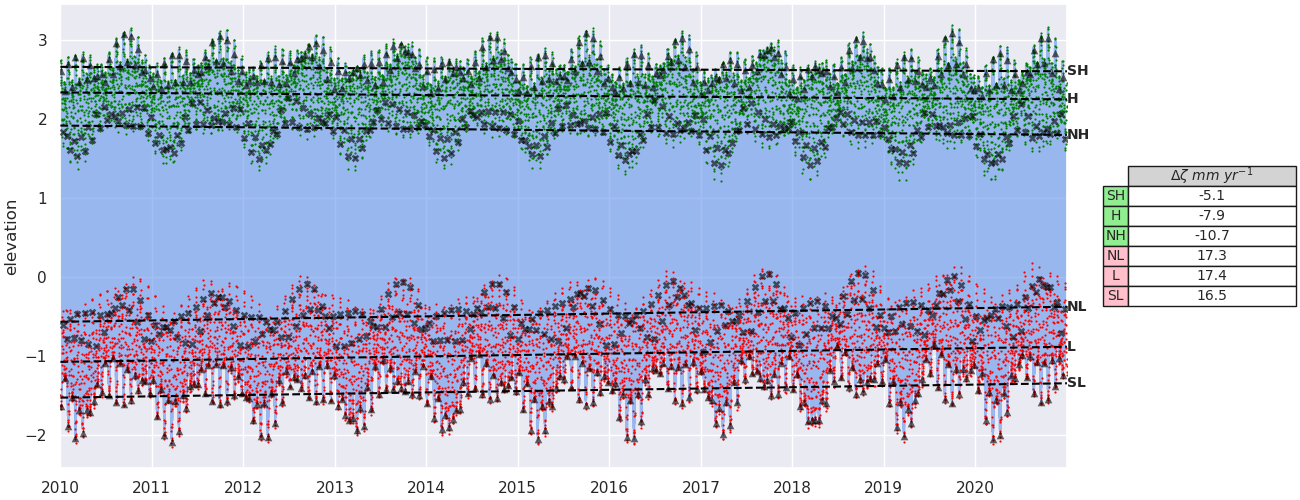

In [19]:
tides.lm_plot()

In [ ]:
tides.lm_plot()

In [3]:
ssc = pd.DataFrame(data={"month": np.tile(np.arange(1, 13, 1), 2), "ssc": np.nan})
ssc.loc[ssc.month==6, "ssc"] = 0.1
ssc.loc[ssc.month==9, "ssc"] = 0.4
ssc = ssc.interpolate(method="cubicspline").loc[5:5+11].squeeze().set_index("month").ssc.sort_index()

In [14]:
land_elev_init = [1.5, 2.6]
slr = [0, 0.005, 0.01]
beta = [0, 0.01, 0.02]
conc_bound = [ssc * 0.5, ssc, ssc * 2]
grain_diam = [2.5e-5 * 0.5, 2.5e-5, 2.5e-5 * 2]
# grain_diam = 2.5e-5
bulk_dens = [800, 1000, 1200]

combos = features.make_combos(land_elev_init=land_elev_init, slr=slr, beta=beta, conc_bound=conc_bound, grain_diam=grain_diam, bulk_dens=bulk_dens)

In [15]:
params = combos[0]
"result_z-{:.2f}_conc-{:.2f}_gs-{:.1e}_bd-{}".format(params.land_elev_init, params.conc_bound.max(), params.grain_diam, params.bulk_dens)

'result_z-1.50_conc-0.20_gs-1.3e-05_bd-800'

In [16]:
    name = "result_z-{:.2f}_conc-{:.2f}_gs-{:.1e}_bd-{}.feather".format(params.land_elev_init, params.conc_bound.max(), params.grain_diam, params.bulk_dens)
    path = r"/home/chris/projects/tidal_flat_0d/data/results" + name

In [17]:
path

'/home/chris/projects/tidal_flat_0d/data/resultsresult_z-1.50_conc-0.20_gs-1.3e-05_bd-800.feather'

In [17]:
def simulate(tides, params):
    
    tf = models.TidalFlat(
        tides=tides.calc_elevation(beta=params.beta, trend=params.slr),
        land_elev_init=params.land_elev_init,
        conc_bound=params.conc_bound.values,
        grain_diam=params.grain_diam,
        grain_dens=2.65e3,
        bulk_dens=params.bulk_dens,
        org_rate_yr=2e-4,
        comp_rate_yr=4e-3,
        sub_rate_yr=3e-3,
        pbar_pos=params.n,
    )
    tf.run()
    
    return([params, tf.results])

In [ ]:
results = Parallel(n_jobs=10, verbose=10)(delayed(simulate)(tides=tides, params=param) for param in combos)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


  0%|          | 0/18262 [00:00<?, ?Day/s, Date=2010-01-01]


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed: 19.8min


  0%|          | 0/18262 [00:00<?, ?Day/s, Date=2010-01-01]


/opt/jupyterhub/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | 0/18262 [00:00<?, ?Day/s, Date=2010-01-01]


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 34.7min


  0%|          | 0/18262 [00:00<?, ?Day/s, Date=2010-01-01]


[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 57.3min


In [ ]:
tf = models.TidalFlat(
    tides=tides.calc_elevation(beta=0.01, trend=0.005),
    land_elev_init=2.6,
    conc_bound=ssc.values,
    grain_diam=2.5e-5,
    grain_dens=2.65e3,
    bulk_dens=800,
    org_rate_yr=2e-4,
    comp_rate_yr=4e-3,
    sub_rate_yr=3e-3,
    pbar_pos=2,
)
tf.run()

In [ ]:
results = tf.results.set_index("datetime")

In [ ]:
dz = results.land_elev.resample("365.25D").mean().diff()
dt = dz.index.to_series().diff().dt.total_seconds()

In [ ]:
fig, ax = plt.subplots()

(dz/dt).plot(ax=ax)

In [ ]:
dfs = []
for i in tf.inundations:
    start = i.df.datetime.iat[0]
    end = i.df.datetime.iat[-1]
    hp = end - start
    depth = (i.df.tide_elev - i.df.land_elev).max()
    aggr = i.df.aggr.iat[-1]
    aggr_max = i.df.aggr_max.iat[-1]
    max_step = (i.result.t - i.result.t[0]).max() / 60
    dfs.append(pd.DataFrame(data={"hp": hp, "depth": depth, "aggr": aggr, "aggr_max": aggr_max, "max_step": max_step}, index=[start]))

inundations = pd.concat(dfs)
yearly = inundations.groupby(inundations.index.year).agg({"hp": "median", "depth": "median", "aggr": "sum"})
yearly["elev_delta"] = res.land_elev.groupby(res.index.year).apply(lambda x: x[-1] - x[0])

In [ ]:
fig, ax = plt.subplots(figsize=(13, 10), nrows=4, constrained_layout=True, sharex=True)

start = "2010"
end = "2120"

(yearly.loc[start:end].hp.dt.total_seconds() / 60 / 60).plot(ax=ax[0], ylabel="median hydroperiod (H)")
(yearly.loc[start:end].depth * 100).plot(ax=ax[1], ylabel="median depth (cm)")
(yearly.loc[start:end].aggr * 100).plot(ax=ax[2], ylabel="yearly aggradation (cm)")
(yearly.loc[start:end].elev_delta * 100).plot(ax=ax[3], ylabel="elevation change (cm)")

for a in ax:
    a.axvline(x=2020, ls=":", color="black")

In [ ]:
tf.plot(frac=0.01)